**Objectives**
- Build a collaborative filtering–based movie recommendation system that generates personalized top-5 movie recommendations using user rating data
- Train and compare multiple collaborative filtering models (SVD, KNNBasic, KNNBaseline) to identify the best-performing approach for predicting user preferences
- Evaluate recommendation accuracy using appropriate regression metrics (RMSE and MAE) on unseen data to assess model performance
- Generate actionable recommendations for both existing and new users, including a cold-start strategy for users with little or no rating history

In [ ]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise import SVD, KNNBasic, KNNBaseline


In [ ]:
#loading the datasets
ratings = pd.read_csv("data/ratings.csv")
movies = pd.read_csv("data/movies.csv")

In [ ]:
print("Ratings shape:", ratings.shape)
print("Movies shape :", movies.shape)

ratings.head(), movies.head()

Ratings shape: (90274, 3)
Movies shape : (9742, 3)


(   userId  movieId  rating
 0       1        1     4.0
 1       1        3     4.0
 2       1        6     4.0
 3       1       47     5.0
 4       1       50     5.0,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  )

In [ ]:
#Merge
df = ratings.merge(
    movies,
    on="movieId",
    how="left"
)

print("Merged df shape:", df.shape)
df.head()

Merged df shape: (90274, 5)


,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
#Cleaning and d.types
df = df.drop(columns=["timestamp"], errors="ignore")
df["userId"] = df["userId"].astype(int)
df["movieId"] = df["movieId"].astype(int)
df["rating"] = df["rating"].astype(float)

#Handle any missing titles/genres safely
df["title"] = df["title"].fillna("Unknown Title")
df["genres"] = df["genres"].fillna("Unknown")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90274 entries, 0 to 90273
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   90274 non-null  int32  
 1   movieId  90274 non-null  int32  
 2   rating   90274 non-null  float64
 3   title    90274 non-null  object 
 4   genres   90274 non-null  object 
dtypes: float64(1), int32(2), object(2)
memory usage: 3.4+ MB


**EDA**

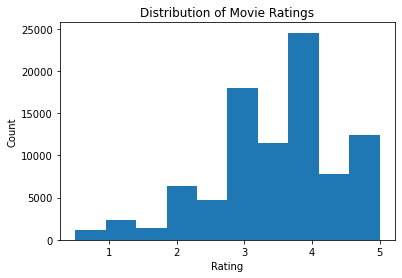

In [ ]:
#ratings distribution
plt.figure()
plt.hist(df["rating"], bins=10)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

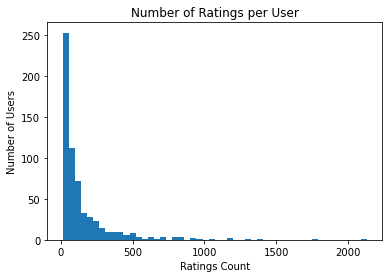

In [ ]:
#ratings per user
ratings_per_user = df.groupby("userId")["rating"].count()

plt.figure()
plt.hist(ratings_per_user, bins=50)
plt.title("Number of Ratings per User")
plt.xlabel("Ratings Count")
plt.ylabel("Number of Users")
plt.show()

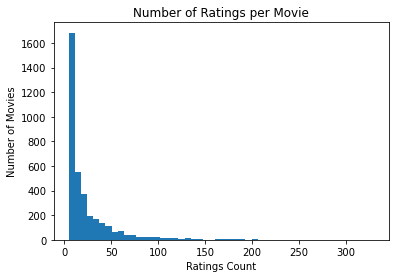

In [ ]:
#ratings per movie
ratings_per_movie = df.groupby("movieId")["rating"].count()

plt.figure()
plt.hist(ratings_per_movie, bins=50)
plt.title("Number of Ratings per Movie")
plt.xlabel("Ratings Count")
plt.ylabel("Number of Movies")
plt.show()

In [ ]:
#sparsity estimate
n_users = df["userId"].nunique()
n_items = df["movieId"].nunique()
n_obs = len(df)

sparsity = 1 - (n_obs / (n_users * n_items))
print(f"Unique users: {n_users}")
print(f"Unique movies: {n_items}")
print(f"Total ratings: {n_obs}")
print(f"Approx. sparsity: {sparsity:.4f} (closer to 1 = more sparse)")

Unique users: 610
Unique movies: 3650
Total ratings: 90274
Approx. sparsity: 0.9595 (closer to 1 = more sparse)


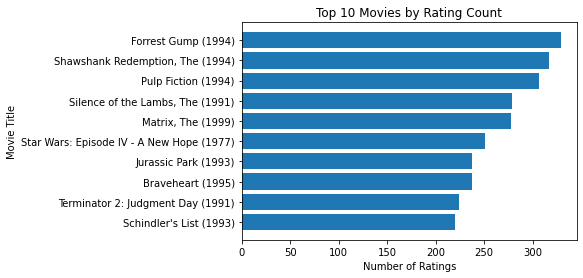

In [ ]:
#top 10 movies by number of ratings
top_movies_counts = (
    df.groupby("title")["rating"]
      .count()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure()
plt.barh(top_movies_counts.index[::-1], top_movies_counts.values[::-1])
plt.title("Top 10 Movies by Rating Count")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.show()

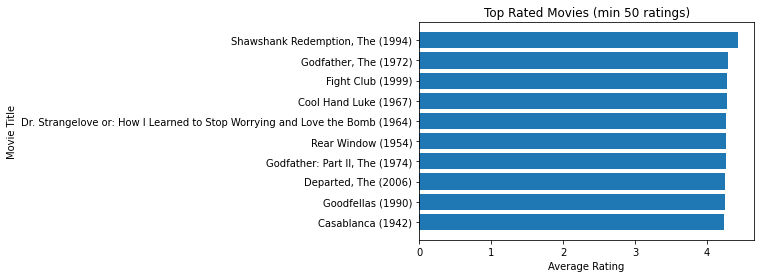

In [ ]:
#top rated movies-with minimum number of ratings
MIN_RATINGS_FOR_TOP = 50
top_rated = (
    df.groupby("title")["rating"]
      .agg(["mean", "count"])
      .query("count >= @MIN_RATINGS_FOR_TOP")
      .sort_values(["mean", "count"], ascending=False)
      .head(10)
)

plt.figure()
plt.barh(top_rated.index[::-1], top_rated["mean"].values[::-1])
plt.title(f"Top Rated Movies (min {MIN_RATINGS_FOR_TOP} ratings)")
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.show()


In [ ]:
#sparsity visualization-sampled matrix
sample_users = df["userId"].drop_duplicates().sample(30, random_state=42)
sample_movies = df["movieId"].drop_duplicates().sample(30, random_state=42)

sample_df = df[df["userId"].isin(sample_users) & df["movieId"].isin(sample_movies)]
pivot = sample_df.pivot_table(index="userId", columns="movieId", values="rating")

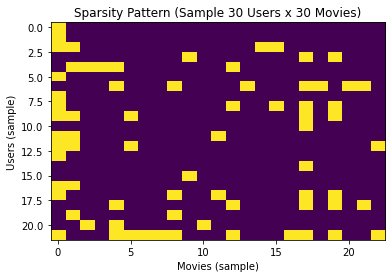

In [ ]:
plt.figure()
plt.imshow(pivot.notna(), aspect="auto")
plt.title("Sparsity Pattern (Sample 30 Users x 30 Movies)")
plt.xlabel("Movies (sample)")
plt.ylabel("Users (sample)")
plt.show()

In [ ]:
#filter sparse Users/Movies
MIN_USER_RATINGS = 20
MIN_MOVIE_RATINGS = 20

user_counts = df.groupby("userId")["rating"].count()
movie_counts = df.groupby("movieId")["rating"].count()

keep_users = user_counts[user_counts >= MIN_USER_RATINGS].index
keep_movies = movie_counts[movie_counts >= MIN_MOVIE_RATINGS].index

df_filtered = df[df["userId"].isin(keep_users) & df["movieId"].isin(keep_movies)].copy()

print("Filtered df shape:", df_filtered.shape)
print("Filtered unique users:", df_filtered["userId"].nunique())
print("Filtered unique movies:", df_filtered["movieId"].nunique())


Filtered df shape: (67809, 5)
Filtered unique users: 602
Filtered unique movies: 1297


In [ ]:
#surprise dataset setup
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(
    df_filtered[["userId", "movieId", "rating"]],
    reader
)

#training/testing split for final evaluation
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
#baseline
global_mean = df_filtered["rating"].mean()
print(f"Baseline (global mean rating): {global_mean:.3f}")

Baseline (global mean rating): 3.623


In [ ]:
#Model 1 - SVD + Grid Search
svd_params = {
    "n_factors": [20, 50, 100],
    "reg_all": [0.02, 0.05, 0.1],
}

gs_svd = GridSearchCV(
    SVD,
    param_grid=svd_params,
    measures=["rmse", "mae"],
    cv=3,
    n_jobs=-1
)

gs_svd.fit(data)

best_rmse = gs_svd.best_score["rmse"]
best_params = gs_svd.best_params["rmse"]

print("Best SVD RMSE:", best_rmse)
print("Best SVD params:", best_params)


Best SVD RMSE: 0.8454476753552317
Best SVD params: {'n_factors': 100, 'reg_all': 0.1}


In [ ]:
#training final SVD on trainset, evaluate on holdout testset
final_svd = SVD(n_factors=best_params["n_factors"], reg_all=best_params["reg_all"])
final_svd.fit(trainset)

svd_predictions = final_svd.test(testset)
print("\nFinal SVD Holdout Performance:")
accuracy.rmse(svd_predictions)
accuracy.mae(svd_predictions)


Final SVD Holdout Performance:
RMSE: 0.8399
MAE:  0.6438


0.6437871040021947

In [ ]:
#model 2 - KNN
sim_options = {"name": "pearson", "user_based": True}

knn_basic = KNNBasic(sim_options=sim_options)
knn_baseline = KNNBaseline(sim_options=sim_options)

cv_knn_basic = cross_validate(knn_basic, data, measures=["RMSE", "MAE"], cv=3, n_jobs=-1, verbose=False)
cv_knn_baseline = cross_validate(knn_baseline, data, measures=["RMSE", "MAE"], cv=3, n_jobs=-1, verbose=False)

print("\nKNN Cross-Validation Results:")
print(f"KNNBasic    Mean RMSE: {np.mean(cv_knn_basic['test_rmse']):.4f} | Mean MAE: {np.mean(cv_knn_basic['test_mae']):.4f}")
print(f"KNNBaseline Mean RMSE: {np.mean(cv_knn_baseline['test_rmse']):.4f} | Mean MAE: {np.mean(cv_knn_baseline['test_mae']):.4f}")



KNN Cross-Validation Results:
KNNBasic    Mean RMSE: 0.9331 | Mean MAE: 0.7212
KNNBaseline Mean RMSE: 0.8462 | Mean MAE: 0.6459


In [ ]:
#visualize Model Comparison(RMSE/MAE)
model_names = ["SVD (Holdout)", "KNNBasic (CV)", "KNNBaseline (CV)"]

rmse_vals = [
    accuracy.rmse(svd_predictions, verbose=False),
    np.mean(cv_knn_basic["test_rmse"]),
    np.mean(cv_knn_baseline["test_rmse"])
]

mae_vals = [
    accuracy.mae(svd_predictions, verbose=False),
    np.mean(cv_knn_basic["test_mae"]),
    np.mean(cv_knn_baseline["test_mae"])
]

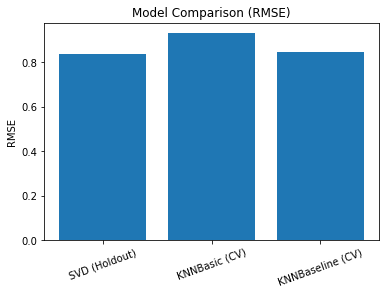

In [ ]:
#RMSE bar chart
plt.figure()
plt.bar(model_names, rmse_vals)
plt.title("Model Comparison (RMSE)")
plt.ylabel("RMSE")
plt.xticks(rotation=20)
plt.show()

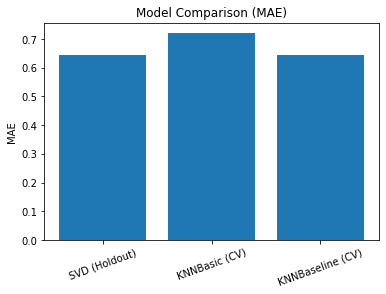

In [ ]:
#MAE bar chart
plt.figure()
plt.bar(model_names, mae_vals)
plt.title("Model Comparison (MAE)")
plt.ylabel("MAE")
plt.xticks(rotation=20)
plt.show()

In [ ]:
#Recommendation Functions (Top-N + Cold Start)
def recommend_top_n(algo, df_all, user_id, n=5, genre=None):
    """
    Recommend top N movies for a given user_id based on predicted rating.
    """
    rated_movie_ids = set(df_all.loc[df_all["userId"] == user_id, "movieId"].unique())
    candidate_movie_ids = df_all["movieId"].unique()

    preds = []
    for m_id in candidate_movie_ids:
        if m_id in rated_movie_ids:
            continue

        if genre:
            g = df_all.loc[df_all["movieId"] == m_id, "genres"].iloc[0]
            if pd.isna(g) or genre.lower() not in str(g).lower():
                continue

        est = algo.predict(user_id, m_id).est
        title = df_all.loc[df_all["movieId"] == m_id, "title"].iloc[0]
        preds.append((m_id, title, est))

    preds.sort(key=lambda x: x[2], reverse=True)
    top = preds[:n]

    return pd.DataFrame(
        [{"movieId": m, "title": t, "predicted_rating": round(r, 2)} for m, t, r in top]
    )


In [ ]:
def cold_start_top_movies(df_all, n=5, min_ratings=50, genre=None):
    """
    Cold-start fallback: recommend popular/highly rated movies
    among those with at least min_ratings.
    """
    temp = df_all.copy()
    if genre:
        temp = temp[temp["genres"].str.contains(genre, case=False, na=False)]

    stats = (
        temp.groupby(["movieId", "title"])["rating"]
            .agg(["mean", "count"])
            .reset_index()
    )

    stats = stats[stats["count"] >= min_ratings].sort_values(["mean", "count"], ascending=False)
    return stats.head(n)


In [ ]:
#example Recommendations
example_user = int(df_filtered["userId"].iloc[0])

print(f"\nTop-5 recommendations for existing user {example_user}:")
display(recommend_top_n(final_svd, df_filtered, user_id=example_user, n=5))

print("\nCold-start recommendations (top movies overall):")
display(cold_start_top_movies(df_filtered, n=5, min_ratings=50))



Top-5 recommendations for existing user 1:


,movieId,title,predicted_rating
0,720,Wallace & Gromit: The Best of Aardman Animatio...,5.00
1,904,Rear Window (1954),5.00
2,1204,Lawrence of Arabia (1962),5.00
3,750,Dr. Strangelove or: How I Learned to Stop Worr...,4.96
4,898,"Philadelphia Story, The (1940)",4.96



Cold-start recommendations (top movies overall):


,movieId,title,mean,count
105,318,"Shawshank Redemption, The (1994)",4.429022,317
230,858,"Godfather, The (1972)",4.302632,190
674,2959,Fight Club (1999),4.272936,218
360,1276,Cool Hand Luke (1967),4.271930,57
212,750,Dr. Strangelove or: How I Learned to Stop Worr...,4.265625,96
